# Churn Prediction - Feature Engineering
---
**Table of Contents** :
1. Import packages and Define functions
2. Load data
3. Feature Engineering
    - Create variables that capture price differentials, reflecting customer price sensitivity
    - Transform `datetime` features into numeric values representing the number of months (as integers)
4. Data Preprocessing
   - Encoding Categorical Data
   - Addressing Skewness in Numerical Data
   - Correlation Analysis
5. Export the data for modeling

---
## 1. Import packages and Define functions

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
from datetime import datetime
from scipy.stats import skew
# Shows plots in jupyter notebook
%matplotlib inline


# Set plot style
sns.set(color_codes=True)
plt.style.use('ggplot')

#### visualization function

In [3]:
def plot_stacked_bars(dataframe, title_, size_=(18, 10), rot_=0, legend_="upper right"):
    """
    Plot stacked bars with annotations
    """
    ax = dataframe.plot(
        kind="bar",
        stacked=True,
        figsize=size_,
        rot=rot_,
        title=title_
    )

    # Annotate bars
    annotate_stacked_bars(ax, textsize=14)
    # Rename legend
    plt.legend(dataframe.columns, loc=legend_)
    # Labels
    plt.ylabel("Company base (%)")
    plt.show()

def annotate_stacked_bars(ax, bins_, pad=0.99, colour="black", textsize=13):
    """
    Add value annotations to the bars
    """
    #print(len(ax.patches))
    # Iterate over the plotted rectanges/bars
    for i in range(len(ax.patches)):
        

        if (i<bins_) :
        # Calculate annotation
            bar_total_height = (ax.patches[i].get_height() + ax.patches[i+int(bins_)].get_height())
        else :
            bar_total_height = (ax.patches[i].get_height() + ax.patches[i-int(bins_)].get_height())

        
        value = (ax.patches[i].get_height()/ bar_total_height) * 100

        if (np.isnan(value) or value < 5 or (bar_total_height < 50)):
            continue
            
        value = str(round(value,1)) + '%'
        #print(value)
        
        ax.annotate(
            value,
            #((p.get_x()+ p.get_width()/2)*pad-0.05, (p.get_y()+p.get_height()/2)*pad),
            ((ax.patches[i].get_x()), (ax.patches[i].get_y()+ax.patches[i].get_height()/2)*pad),
            color=colour,
            size=textsize
        )

def plot_distribution(dataframe, column, ax, bins_=50):
    """
    Plot variable distirbution in a stacked histogram of churned or retained company
    """
    # Create a temporal dataframe with the data to be plot
    temp = pd.DataFrame({"Retention": dataframe[dataframe["churn"]==0][column],
    "Churn":dataframe[dataframe["churn"]==1][column]})

    #print(temp)
    # Plot the histogram
    temp[["Retention", "Churn"]].plot(kind='hist', bins=bins_, ax=ax, stacked=True)
    # X-axis label
    ax.set_xlabel(column)
    # Change the x-axis to plain style
    ax.ticklabel_format(style='plain', axis='x')
    annotate_stacked_bars(ax, bins_ = bins_, textsize=14)


---
## 2. Load data

In [4]:
client_df = pd.read_csv('./data/client_data.csv')
price_df = pd.read_csv('./data/price_data.csv')

In [5]:
client_df.head()

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  d29c2c54acc38ff3c0614d0a653813dd                           MISSING   
2  764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   
3  bba03439a292a1e166f80264c16191cb  lmkebamcaaclubfxadlmueccxoimlema   
4  149d57cf92fc41cf94415803a877cb4b                           MISSING   

   cons_12m  cons_gas_12m  cons_last_month  date_activ    date_end  \
0         0         54946                0  2013-06-15  2016-06-15   
1      4660             0                0  2009-08-21  2016-08-30   
2       544             0                0  2010-04-16  2016-04-16   
3      1584             0                0  2010-03-30  2016-03-30   
4      4425             0              526  2010-01-13  2016-03-07   

  date_modif_prod date_renewal  forecast_cons_12m  ...  has_gas  imp_cons  \
0      2015-11-01   2015-06-23               0.00  ...        t      0.00   
1      2009-08-21   2015-08-31             189.95  ...        f      0.00   
2      2010-04-16   2015-04-17              47.96  ...        f      0.00   
3      2010-03-30   2015-03-31             240.04  ...        f      0.00   
4      2010-01-13   2015-03-09             445.75  ...        f     52.32   

   margin_gross_pow_ele  margin_net_pow_ele  nb_prod_act  net_margin  \
0                 25.44               25.44            2      678.99   
1                 16.38               16.38            1       18.89   
2                 28.60               28.60            1        6.60   
3                 30.22               30.22            1       25.46   
4                 44.91               44.91            1       47.98   

  num_years_antig                         origin_up  pow_max  churn  
0               3  lxidpiddsbxsbosboudacockeimpuepw   43.648      1  
1               6  kamkkxfxxuwbdslkwifmmcsiusiuosws   13.800      0  
2               6  kamkkxfxxuwbdslkwifmmcsiusiuosws   13.856      0  
3               6  kamkkxfxxuwbdslkwifmmcsiusiuosws   13.200      0  
4               6  kamkkxfxxuwbdslkwifmmcsiusiuosws   19.800      0  

[5 rows x 26 columns]

In [6]:
price_df.head()

id  price_date  price_off_peak_var  \
0  038af19179925da21a25619c5a24b745  2015-01-01            0.151367   
1  038af19179925da21a25619c5a24b745  2015-02-01            0.151367   
2  038af19179925da21a25619c5a24b745  2015-03-01            0.151367   
3  038af19179925da21a25619c5a24b745  2015-04-01            0.149626   
4  038af19179925da21a25619c5a24b745  2015-05-01            0.149626   

   price_peak_var  price_mid_peak_var  price_off_peak_fix  price_peak_fix  \
0             0.0                 0.0           44.266931             0.0   
1             0.0                 0.0           44.266931             0.0   
2             0.0                 0.0           44.266931             0.0   
3             0.0                 0.0           44.266931             0.0   
4             0.0                 0.0           44.266931             0.0   

   price_mid_peak_fix  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0

### Dataset Description

**client_data** :
- id = client company identifier
- channel_sales = code of the sales channel
- cons_12m = electricity consumption of the past 12 months
- cons_gas_12m = gas consumption of the past 12 months
- cons_last_month = electricity consumption of the last month
- date_activ = date of activation of the contract
- date_end = registered date of the end of the contract
- date_modif_prod = date of the last modification of the product
- date_renewal = date of the next contract renewal
- forecast_cons_12m = forecasted electricity consumption for next 12 months
- forecast_cons_year = forecasted electricity consumption for the next calendar year
- forecast_discount_energy = forecasted value of current discount
- forecast_meter_rent_12m = forecasted bill of meter rental for the next 2 months
- forecast_price_energy_off_peak = forecasted energy price for 1st period (off peak)
- forecast_price_energy_peak = forecasted energy price for 2nd period (peak)
- forecast_price_pow_off_peak = forecasted power price for 1st period (off peak)
- has_gas = indicated if client is also a gas client
- imp_cons = current paid consumption
- margin_gross_pow_ele = gross margin on power subscription
- margin_net_pow_ele = net margin on power subscription
- nb_prod_act = number of active products and services
- net_margin = total net margin
- num_years_antig = antiquity of the client (in number of years)
- origin_up = code of the electricity campaign the customer first subscribed to
- pow_max = subscribed power
- churn = has the client churned over the next 3 months


**price_data**:
- id = client company identifier
- price_date = reference date
- price_off_peak_var = price of energy for the 1st period (off peak)
- price_peak_var = price of energy for the 2nd period (peak)
- price_mid_peak_var = price of energy for the 3rd period (mid peak)
- price_off_peak_fix = price of power for the 1st period (off peak)
- price_peak_fix = price of power for the 2nd period (peak)
- price_mid_peak_fix = price of power for the 3rd period (mid peak)

---
## 3. Feature Engineering

### Annual Price Rate Differentials (January vs December)
> **New Features**: Changes in Time-of-Use Rates
> - Peak Rate Delta
> - Mid-Peak Rate Delta
> - Off-Peak Rate Delta
>
> **Hypothesis**: Significant annual price changes between January and December may impact customer churn decisions.

**Data Preprocessing: Converting Date Fields to Datetime Format**

In [7]:
client_df["date_activ"] = pd.to_datetime(client_df["date_activ"], format='%Y-%m-%d')
client_df["date_end"] = pd.to_datetime(client_df["date_end"], format='%Y-%m-%d')
client_df["date_modif_prod"] = pd.to_datetime(client_df["date_modif_prod"], format='%Y-%m-%d')
client_df["date_renewal"] = pd.to_datetime(client_df["date_renewal"], format='%Y-%m-%d')

In [8]:
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

id price_date  price_off_peak_var  \
0  038af19179925da21a25619c5a24b745 2015-01-01            0.151367   
1  038af19179925da21a25619c5a24b745 2015-02-01            0.151367   
2  038af19179925da21a25619c5a24b745 2015-03-01            0.151367   
3  038af19179925da21a25619c5a24b745 2015-04-01            0.149626   
4  038af19179925da21a25619c5a24b745 2015-05-01            0.149626   

   price_peak_var  price_mid_peak_var  price_off_peak_fix  price_peak_fix  \
0             0.0                 0.0           44.266931             0.0   
1             0.0                 0.0           44.266931             0.0   
2             0.0                 0.0           44.266931             0.0   
3             0.0                 0.0           44.266931             0.0   
4             0.0                 0.0           44.266931             0.0   

   price_mid_peak_fix  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0

In [9]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean','price_peak_var' : 'mean','price_peak_fix' : 'mean','price_mid_peak_var' : 'mean','price_mid_peak_fix' : 'mean' }).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1_off_peak', 'price_off_peak_fix': 'dec_2_off_peak','price_peak_var' : 'dec_1_peak','price_peak_fix' : 'dec_2_peak','price_mid_peak_var' : 'dec_1_mid_peak', 'price_mid_peak_fix' : 'dec_2_mid_peak' }), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1_off_peak'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2_off_peak'] - diff['price_off_peak_fix']
diff['peak_diff_dec_january_energy'] = diff['dec_1_peak'] - diff['price_peak_var']
diff['peak_diff_dec_january_power'] = diff['dec_2_peak'] - diff['price_peak_fix']
diff['midpeak_diff_dec_january_energy'] = diff['dec_1_mid_peak'] - diff['price_mid_peak_var']
diff['midpeak_diff_dec_january_power'] = diff['dec_2_mid_peak'] - diff['price_mid_peak_fix']

diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power','peak_diff_dec_january_energy','peak_diff_dec_january_power','midpeak_diff_dec_january_energy','midpeak_diff_dec_january_power']]
diff.head()

id  offpeak_diff_dec_january_energy  \
0  0002203ffbb812588b632b9e628cc38d                        -0.006192   
1  0004351ebdd665e6ee664792efc4fd13                        -0.004104   
2  0010bcc39e42b3c2131ed2ce55246e3c                         0.050443   
3  0010ee3855fdea87602a5b7aba8e42de                        -0.010018   
4  00114d74e963e47177db89bc70108537                        -0.003994   

   offpeak_diff_dec_january_power  peak_diff_dec_january_energy  \
0                        0.162916                     -0.002302   
1                        0.177779                      0.000000   
2                        1.500000                      0.000000   
3                        0.162916                     -0.005120   
4                       -0.000001                      0.000000   

   peak_diff_dec_january_power  midpeak_diff_dec_january_energy  \
0                     0.097749                         0.003487   
1                     0.000000                         0.000000   
2                     0.000000                         0.000000   
3                     0.097749                         0.000763   
4                     0.000000                         0.000000   

   midpeak_diff_dec_january_power  
0                        0.065166  
1                        0.000000  
2                        0.000000  
3                        0.065166  
4                        0.000000

In [10]:
df = pd.merge(client_df, diff, on='id')
df.head()

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  d29c2c54acc38ff3c0614d0a653813dd                           MISSING   
2  764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   
3  bba03439a292a1e166f80264c16191cb  lmkebamcaaclubfxadlmueccxoimlema   
4  149d57cf92fc41cf94415803a877cb4b                           MISSING   

   cons_12m  cons_gas_12m  cons_last_month date_activ   date_end  \
0         0         54946                0 2013-06-15 2016-06-15   
1      4660             0                0 2009-08-21 2016-08-30   
2       544             0                0 2010-04-16 2016-04-16   
3      1584             0                0 2010-03-30 2016-03-30   
4      4425             0              526 2010-01-13 2016-03-07   

  date_modif_prod date_renewal  forecast_cons_12m  ...  num_years_antig  \
0      2015-11-01   2015-06-23               0.00  ...                3   
1      2009-08-21   2015-08-31             189.95  ...                6   
2      2010-04-16   2015-04-17              47.96  ...                6   
3      2010-03-30   2015-03-31             240.04  ...                6   
4      2010-01-13   2015-03-09             445.75  ...                6   

                          origin_up  pow_max  churn  \
0  lxidpiddsbxsbosboudacockeimpuepw   43.648      1   
1  kamkkxfxxuwbdslkwifmmcsiusiuosws   13.800      0   
2  kamkkxfxxuwbdslkwifmmcsiusiuosws   13.856      0   
3  kamkkxfxxuwbdslkwifmmcsiusiuosws   13.200      0   
4  kamkkxfxxuwbdslkwifmmcsiusiuosws   19.800      0   

   offpeak_diff_dec_january_energy  offpeak_diff_dec_january_power  \
0                         0.020057                        3.700961   
1                        -0.003767                        0.177779   
2                        -0.004670                        0.177779   
3                        -0.004547                        0.177779   
4                        -0.006192                        0.162916   

  peak_diff_dec_january_energy  peak_diff_dec_january_power  \
0                    -0.017912                   -24.339581   
1                     0.000000                     0.000000   
2                     0.000528                     0.000000   
3                     0.000000                     0.000000   
4                    -0.002302                     0.097749   

   midpeak_diff_dec_january_energy  midpeak_diff_dec_january_power  
0                        -0.071536                      -16.226389  
1                         0.000000                        0.000000  
2                         0.000000                        0.000000  
3                         0.000000                        0.000000  
4                         0.003487                        0.065166  

[5 rows x 32 columns]

---

### Period-to-Period Rate Differentials
> **New Features**: Average Price Differences Between Time-of-Use Periods
> 
> **Gas Rates**:
> - Peak vs Off-Peak Difference
> - Mid-Peak vs Peak Difference
> - Off-Peak vs Mid-Peak Difference
>
> **Electricity Rates**:
> - Peak vs Off-Peak Difference
> - Mid-Peak vs Peak Difference
> - Off-Peak vs Mid-Peak Difference
>
> **Hypothesis**: To analyze how price spreads between different time-of-use periods might influence customer churn behavior.

In [11]:
# Aggregate average prices per period by company
mean_prices = price_df.groupby(['id']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [12]:
# Calculate the mean difference between consecutive periods
mean_prices['peak_off_peak_var_mean_diff'] = mean_prices['price_peak_var'] - mean_prices['price_off_peak_var']
mean_prices['mid_peak_peak_var_mean_diff'] = mean_prices['price_mid_peak_var'] - mean_prices['price_peak_var']
mean_prices['off_peak_mid_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['peak_off_peak_fix_mean_diff'] = mean_prices['price_peak_fix'] - mean_prices['price_off_peak_fix']
mean_prices['mid_peak_peak_fix_mean_diff'] = mean_prices['price_mid_peak_fix'] - mean_prices['price_peak_fix']
mean_prices['off_peak_mid_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_mid_peak_fix']

In [13]:
columns = [
    'id', 
    'peak_off_peak_var_mean_diff',
    'mid_peak_peak_var_mean_diff', 
    'off_peak_mid_peak_var_mean_diff',
    'peak_off_peak_fix_mean_diff', 
    'mid_peak_peak_fix_mean_diff', 
    'off_peak_mid_peak_fix_mean_diff'
]
df = pd.merge(df, mean_prices[columns], on='id')
df.head()

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  d29c2c54acc38ff3c0614d0a653813dd                           MISSING   
2  764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   
3  bba03439a292a1e166f80264c16191cb  lmkebamcaaclubfxadlmueccxoimlema   
4  149d57cf92fc41cf94415803a877cb4b                           MISSING   

   cons_12m  cons_gas_12m  cons_last_month date_activ   date_end  \
0         0         54946                0 2013-06-15 2016-06-15   
1      4660             0                0 2009-08-21 2016-08-30   
2       544             0                0 2010-04-16 2016-04-16   
3      1584             0                0 2010-03-30 2016-03-30   
4      4425             0              526 2010-01-13 2016-03-07   

  date_modif_prod date_renewal  forecast_cons_12m  ...  \
0      2015-11-01   2015-06-23               0.00  ...   
1      2009-08-21   2015-08-31             189.95  ...   
2      2010-04-16   2015-04-17              47.96  ...   
3      2010-03-30   2015-03-31             240.04  ...   
4      2010-01-13   2015-03-09             445.75  ...   

   peak_diff_dec_january_energy  peak_diff_dec_january_power  \
0                     -0.017912                   -24.339581   
1                      0.000000                     0.000000   
2                      0.000528                     0.000000   
3                      0.000000                     0.000000   
4                     -0.002302                     0.097749   

   midpeak_diff_dec_january_energy  midpeak_diff_dec_january_power  \
0                        -0.071536                      -16.226389   
1                         0.000000                        0.000000   
2                         0.000000                        0.000000   
3                         0.000000                        0.000000   
4                         0.003487                        0.065166   

   peak_off_peak_var_mean_diff  mid_peak_peak_var_mean_diff  \
0                    -0.024038                    -0.034219   
1                    -0.142485                    -0.007124   
2                    -0.082090                    -0.088421   
3                    -0.151210                     0.000000   
4                    -0.020536                    -0.030773   

  off_peak_mid_peak_var_mean_diff  peak_off_peak_fix_mean_diff  \
0                        0.058257                   -18.590255   
1                        0.149609                   -44.311375   
2                        0.170512                   -44.385450   
3                        0.151210                   -44.400265   
4                        0.051309                   -16.275263   

   mid_peak_peak_fix_mean_diff  off_peak_mid_peak_fix_mean_diff  
0                    -7.450670                        26.040925  
1                     0.000000                        44.311375  
2                     0.000000                        44.385450  
3                     0.000000                        44.400265  
4                    -8.137629                        24.412893  

[5 rows x 38 columns]

The dec-jan feature may reveal macro patterns that occur over an entire year, whereas inter-time-period features may reveal patterns on a micro scale between months.

---

### Maximum of Monthly Period-to-Period Rate Differentials
> **New Features**: Maximum Price Differences Between Time-of-Use Periods
> 
> **Gas Rates**:
> - Peak vs Off-Peak Difference
> - Mid-Peak vs Peak Difference
> - Off-Peak vs Mid-Peak Difference
>
> **Electricity Rates**:
> - Peak vs Off-Peak Difference
> - Mid-Peak vs Peak Difference
> - Off-Peak vs Mid-Peak Difference
>
> **Hypothesis**: To analyze how biggest price spreads between different time-of-use periods might influence customer churn behavior.

In [14]:
# Aggregate average prices per period by company
mean_prices_by_month = price_df.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [15]:
mean_prices_by_month

id price_date  price_off_peak_var  \
0       0002203ffbb812588b632b9e628cc38d 2015-01-01            0.126098   
1       0002203ffbb812588b632b9e628cc38d 2015-02-01            0.126098   
2       0002203ffbb812588b632b9e628cc38d 2015-03-01            0.128067   
3       0002203ffbb812588b632b9e628cc38d 2015-04-01            0.128067   
4       0002203ffbb812588b632b9e628cc38d 2015-05-01            0.128067   
...                                  ...        ...                 ...   
192997  ffff7fa066f1fb305ae285bb03bf325a 2015-08-01            0.119916   
192998  ffff7fa066f1fb305ae285bb03bf325a 2015-09-01            0.119916   
192999  ffff7fa066f1fb305ae285bb03bf325a 2015-10-01            0.119916   
193000  ffff7fa066f1fb305ae285bb03bf325a 2015-11-01            0.119916   
193001  ffff7fa066f1fb305ae285bb03bf325a 2015-12-01            0.119916   

        price_peak_var  price_mid_peak_var  price_off_peak_fix  \
0             0.103975            0.070232           40.565969   
1             0.103975            0.070232           40.565969   
2             0.105842            0.073773           40.728885   
3             0.105842            0.073773           40.728885   
4             0.105842            0.073773           40.728885   
...                ...                 ...                 ...   
192997        0.102232            0.076257           40.728885   
192998        0.102232            0.076257           40.728885   
192999        0.102232            0.076257           40.728885   
193000        0.102232            0.076257           40.728885   
193001        0.102232            0.076257           40.728885   

        price_peak_fix  price_mid_peak_fix  
0            24.339581           16.226389  
1            24.339581           16.226389  
2            24.437330           16.291555  
3            24.437330           16.291555  
4            24.437330           16.291555  
...                ...                 ...  
192997       24.437330           16.291555  
192998       24.437330           16.291555  
192999       24.437330           16.291555  
193000       24.437330           16.291555  
193001       24.437330           16.291555  

[193002 rows x 8 columns]

In [16]:

mean_prices_by_month['peak_off_peak_var_mean_diff'] = mean_prices_by_month['price_peak_var'] - mean_prices_by_month['price_off_peak_var']
mean_prices_by_month['mid_peak_peak_var_mean_diff'] = mean_prices_by_month['price_mid_peak_var'] - mean_prices_by_month['price_peak_var']
mean_prices_by_month['off_peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['peak_off_peak_fix_mean_diff'] = mean_prices_by_month['price_peak_fix'] - mean_prices_by_month['price_off_peak_fix']
mean_prices_by_month['mid_peak_peak_fix_mean_diff'] = mean_prices_by_month['price_mid_peak_fix'] - mean_prices_by_month['price_peak_fix']
mean_prices_by_month['off_peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']

In [17]:
# Calculate the maximum monthly difference across time periods
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
    'peak_off_peak_var_mean_diff': 'min',
    'mid_peak_peak_var_mean_diff': 'min',
    'off_peak_mid_peak_var_mean_diff': 'max',
    'peak_off_peak_fix_mean_diff': 'min',
    'mid_peak_peak_fix_mean_diff': 'min',
    'off_peak_mid_peak_fix_mean_diff': 'max'
}).reset_index().rename(
    columns={
        'peak_off_peak_var_mean_diff': 'peak_off_peak_var_max_monthly_diff',
        'mid_peak_peak_var_mean_diff': 'mid_peak_peak_var_max_monthly_diff',
        'off_peak_mid_peak_var_mean_diff': 'off_peak_mid_peak_var_max_monthly_diff',
        'peak_off_peak_fix_mean_diff': 'peak_off_peak_fix_max_monthly_diff',
        'mid_peak_peak_fix_mean_diff': 'mid_peak_peak_fix_max_monthly_diff',
        'off_peak_mid_peak_fix_mean_diff': 'off_peak_mid_peak_fix_max_monthly_diff'
    }
)

In [18]:
columns = [
    'id',
    'peak_off_peak_var_max_monthly_diff',
    'mid_peak_peak_var_max_monthly_diff',
    'off_peak_mid_peak_var_max_monthly_diff',
    'peak_off_peak_fix_max_monthly_diff',
    'mid_peak_peak_fix_max_monthly_diff',
    'off_peak_mid_peak_fix_max_monthly_diff'
]

df = pd.merge(df, max_diff_across_periods_months[columns], on='id')
df.head()

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  d29c2c54acc38ff3c0614d0a653813dd                           MISSING   
2  764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   
3  bba03439a292a1e166f80264c16191cb  lmkebamcaaclubfxadlmueccxoimlema   
4  149d57cf92fc41cf94415803a877cb4b                           MISSING   

   cons_12m  cons_gas_12m  cons_last_month date_activ   date_end  \
0         0         54946                0 2013-06-15 2016-06-15   
1      4660             0                0 2009-08-21 2016-08-30   
2       544             0                0 2010-04-16 2016-04-16   
3      1584             0                0 2010-03-30 2016-03-30   
4      4425             0              526 2010-01-13 2016-03-07   

  date_modif_prod date_renewal  forecast_cons_12m  ...  \
0      2015-11-01   2015-06-23               0.00  ...   
1      2009-08-21   2015-08-31             189.95  ...   
2      2010-04-16   2015-04-17              47.96  ...   
3      2010-03-30   2015-03-31             240.04  ...   
4      2010-01-13   2015-03-09             445.75  ...   

   off_peak_mid_peak_var_mean_diff  peak_off_peak_fix_mean_diff  \
0                         0.058257                   -18.590255   
1                         0.149609                   -44.311375   
2                         0.170512                   -44.385450   
3                         0.151210                   -44.400265   
4                         0.051309                   -16.275263   

   mid_peak_peak_fix_mean_diff  off_peak_mid_peak_fix_mean_diff  \
0                    -7.450670                        26.040925   
1                     0.000000                        44.311375   
2                     0.000000                        44.385450   
3                     0.000000                        44.400265   
4                    -8.137629                        24.412893   

   peak_off_peak_var_max_monthly_diff  mid_peak_peak_var_max_monthly_diff  \
0                           -0.060550                           -0.085483   
1                           -0.151367                           -0.085483   
2                           -0.084587                           -0.089162   
3                           -0.153133                            0.000000   
4                           -0.022225                           -0.033743   

  off_peak_mid_peak_var_max_monthly_diff  peak_off_peak_fix_max_monthly_diff  \
0                               0.146033                          -44.266930   
1                               0.151367                          -44.444710   
2                               0.172468                          -44.444710   
3                               0.153133                          -44.444710   
4                               0.055866                          -16.291555   

   mid_peak_peak_fix_max_monthly_diff  off_peak_mid_peak_fix_max_monthly_diff  
0                           -8.145775                                44.26693  
1                            0.000000                                44.44471  
2                            0.000000                                44.44471  
3                            0.000000                                44.44471  
4                           -8.145775                                24.43733  

[5 rows x 44 columns]

I thought that calculating the maximum price change between months and time periods would be a valuable feature to include, as I wanted to consider the perspective of a PowerCo client. For utility customers, sudden price fluctuations between months can be especially frustrating, and a significant increase within a short time frame could prompt them to explore other providers for better rates. Since our goal is to predict churn in this case, I believe this feature could offer meaningful insights.

---
### Tenure

How long a company has been a client of PowerCo.

In [19]:
df['tenure'] = ((df['date_end'] - df['date_activ']) / np.timedelta64(1, 'D') / 365.25).astype(int)

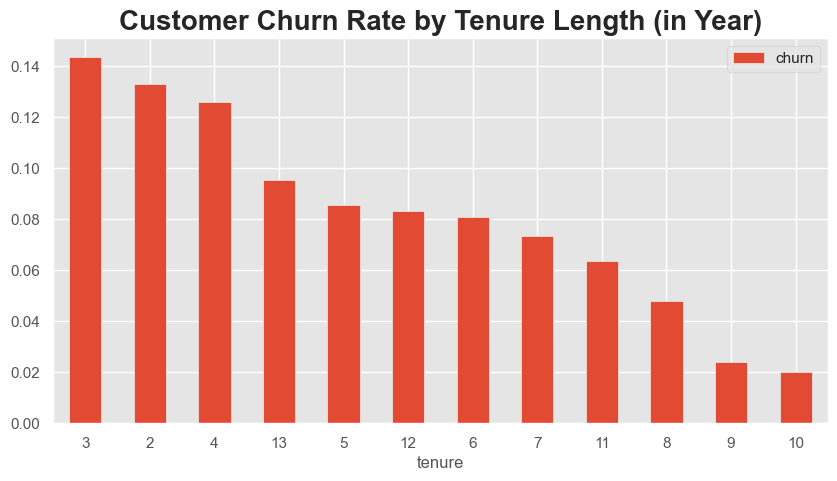

In [20]:
df.groupby(['tenure']).agg({'churn': 'mean'}).sort_values(by='churn', ascending=False).plot(kind='bar',rot=360,figsize=(10,5))
plt.title('Customer Churn Rate by Tenure Length (in Year)', weight = 'bold', fontsize = 20)
plt.show()

We can see that companies who have only been a client for 4 or less years are much more likely to churn compared to companies that have been a client for longer. Interestingly, the difference between 4 and 5 months is about 4%, which represents a large jump in likelihood for a customer to churn compared to the other differences between ordered tenure values. Perhaps this reveals that getting a customer to over 4 months tenure is actually a large milestone with respect to keeping them as a long term customer. 

This is an interesting feature to keep for modelling because clearly how long you've been a client, has a influence on the chance of a client churning.

---
### Transform `datetime` features into numeric values representing the number of months (as integers)

- months_activ = Number of months active until reference date (Jan 2016)
- months_to_end = Number of months of the contract left until reference date (Jan 2016)
- months_modif_prod = Number of months since last modification until reference date (Jan 2016)
- months_renewal = Number of months since last renewal until reference date (Jan 2016)

Dates as a datetime object are not useful for a predictive model, so we needed to use the datetimes to create some other features that may hold some predictive power. 

Using intuition, you could assume that a client who has been an active client of PowerCo for a longer amount of time may have more loyalty to the brand and is more likely to stay. Whereas a newer client may be more volatile. Hence the addition of the `months_activ` feature.

As well as this, if we think from the perspective of a client with PowerCo, if you're coming toward the end of your contract with PowerCo your thoughts could go a few ways. You could be looking for better deals for when your contract ends, or you might want to see out your contract and sign another one. One the other hand if you've only just joined, you may have a period where you're allowed to leave if you're not satisfied. Furthermore, if you're in the middle of your contract, their may be charges if you wanted to leave, deterring clients from churning mid-way through their agreement. So, I think `months_to_end` will be an interesting feature because it may reveal patterns and behaviours about timing of churn.

My belief is that if a client has made recent updates to their contract, they are more likely to be satisfied or at least they have received a level of customer service to update or change their existing services. I believe this to be a positive sign, they are an engaged customer, and so I believe `months_modif_prod` will be an interesting feature to include because it shows the degree of how 'engaged' a client is with PowerCo.

Finally the number of months since a client last renewed a contract I believe will be an interesting feature because once again, it shows the degree to which that client is engaged. It also goes a step further than just engagement, it shows a level of commitment if a client renews their contract. For this reason, I believe `months_renewal` will be a good feature to include.

In [21]:
def convert_months(reference_date, df, column):
    """
    Input a column with timedeltas and return months
    """
    time_delta = reference_date - df[column]
    months = (time_delta / np.timedelta64(1, 'D') / 30.44).astype(int)
    return months


In [22]:
# Create reference date
reference_date = datetime(2016, 1, 1)

# Create columns
df['months_activ'] = convert_months(reference_date, df, 'date_activ')
df['months_to_end'] = -convert_months(reference_date, df, 'date_end')
df['months_modif_prod'] = convert_months(reference_date, df, 'date_modif_prod')
df['months_renewal'] = convert_months(reference_date, df, 'date_renewal')

In [23]:
# We no longer need the datetime columns that we used for feature engineering, so we can drop them
remove = [
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal'
]

df = df.drop(columns=remove)
df.head()

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  d29c2c54acc38ff3c0614d0a653813dd                           MISSING   
2  764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   
3  bba03439a292a1e166f80264c16191cb  lmkebamcaaclubfxadlmueccxoimlema   
4  149d57cf92fc41cf94415803a877cb4b                           MISSING   

   cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
0         0         54946                0               0.00   
1      4660             0                0             189.95   
2       544             0                0              47.96   
3      1584             0                0             240.04   
4      4425             0              526             445.75   

   forecast_cons_year  forecast_discount_energy  forecast_meter_rent_12m  \
0                   0                       0.0                     1.78   
1                   0                       0.0                    16.27   
2                   0                       0.0                    38.72   
3                   0                       0.0                    19.83   
4                 526                       0.0                   131.73   

   forecast_price_energy_off_peak  ...  mid_peak_peak_var_max_monthly_diff  \
0                        0.114481  ...                           -0.085483   
1                        0.145711  ...                           -0.085483   
2                        0.165794  ...                           -0.089162   
3                        0.146694  ...                            0.000000   
4                        0.116900  ...                           -0.033743   

   off_peak_mid_peak_var_max_monthly_diff peak_off_peak_fix_max_monthly_diff  \
0                                0.146033                         -44.266930   
1                                0.151367                         -44.444710   
2                                0.172468                         -44.444710   
3                                0.153133                         -44.444710   
4                                0.055866                         -16.291555   

   mid_peak_peak_fix_max_monthly_diff  off_peak_mid_peak_fix_max_monthly_diff  \
0                           -8.145775                                44.26693   
1                            0.000000                                44.44471   
2                            0.000000                                44.44471   
3                            0.000000                                44.44471   
4                           -8.145775                                24.43733   

   tenure  months_activ  months_to_end  months_modif_prod months_renewal  
0       3            30              5                  2              6  
1       7            76              7                 76              4  
2       6            68              3                 68              8  
3       6            69              2                 69              9  
4       6            71              2                 71              9  

[5 rows x 45 columns]

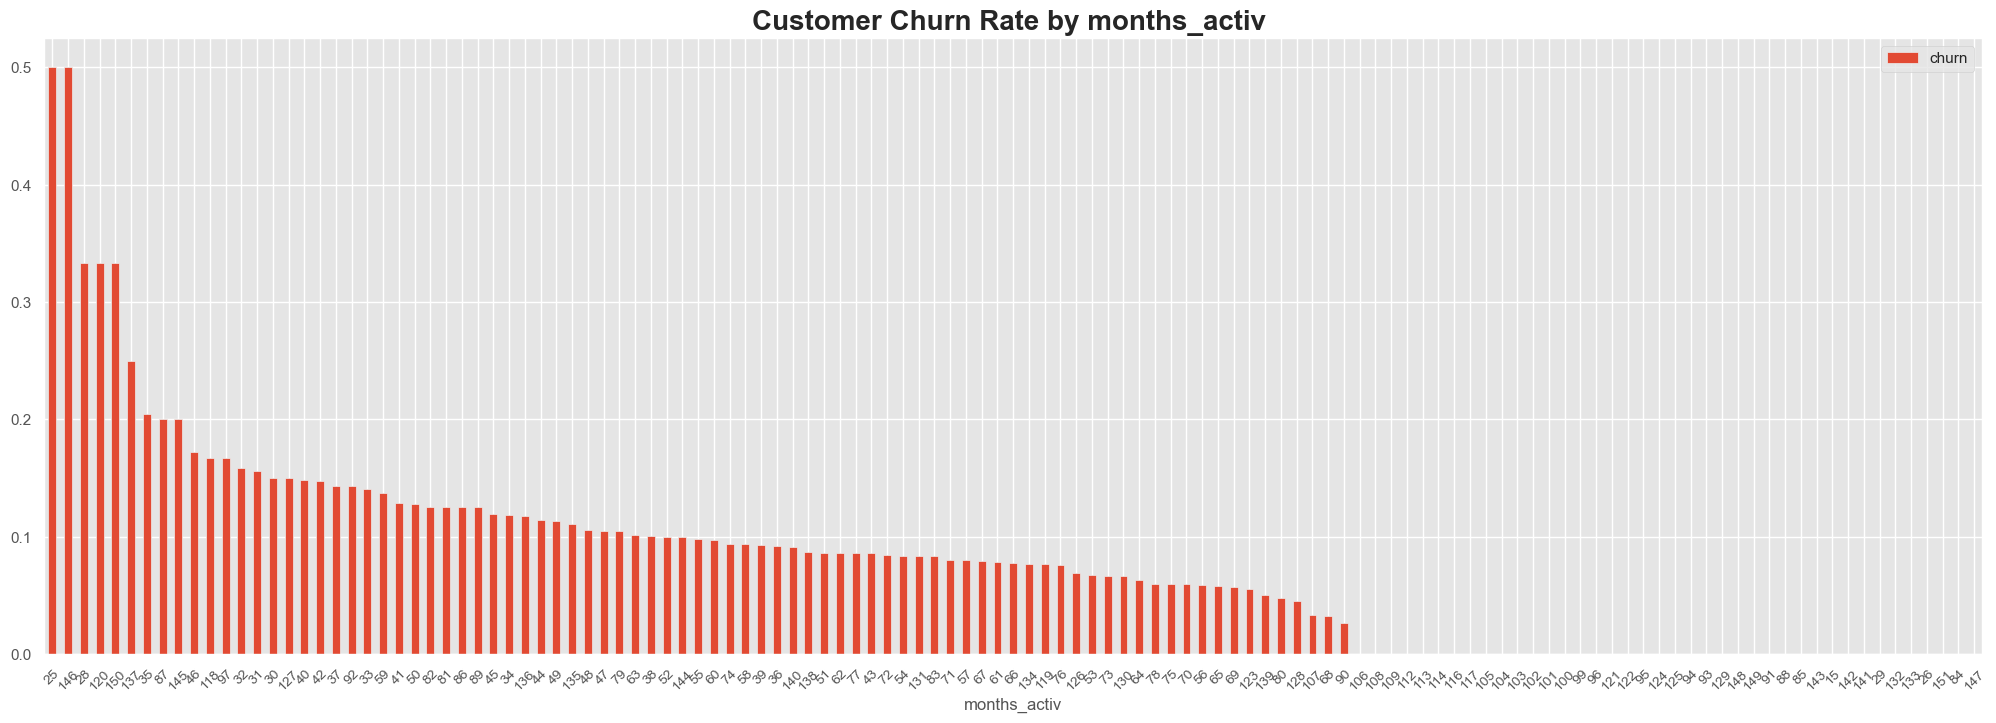

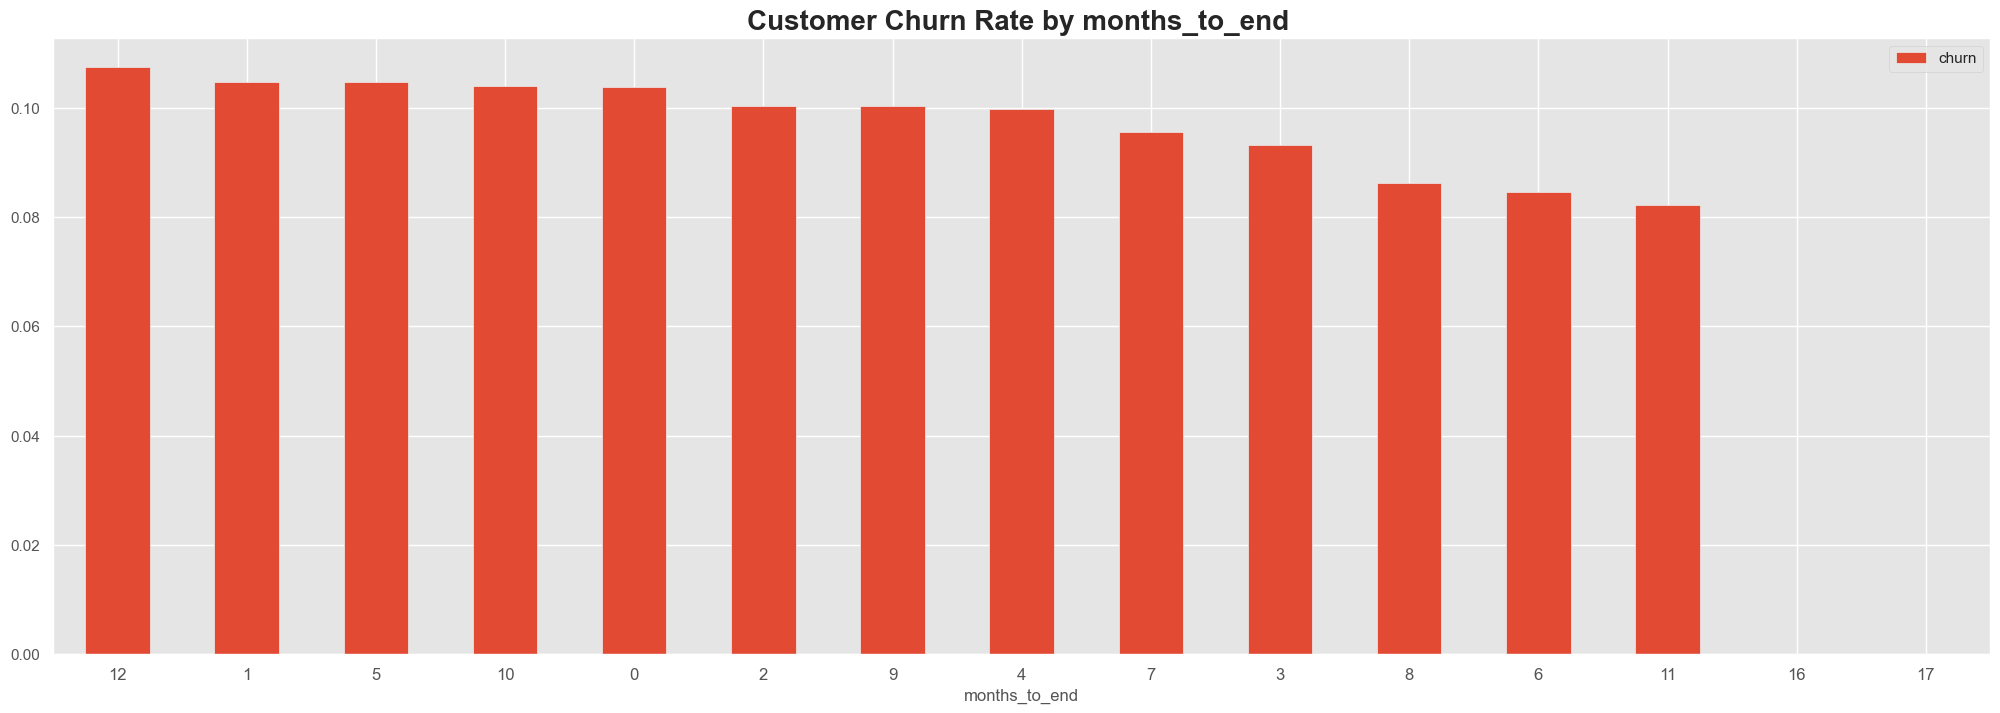

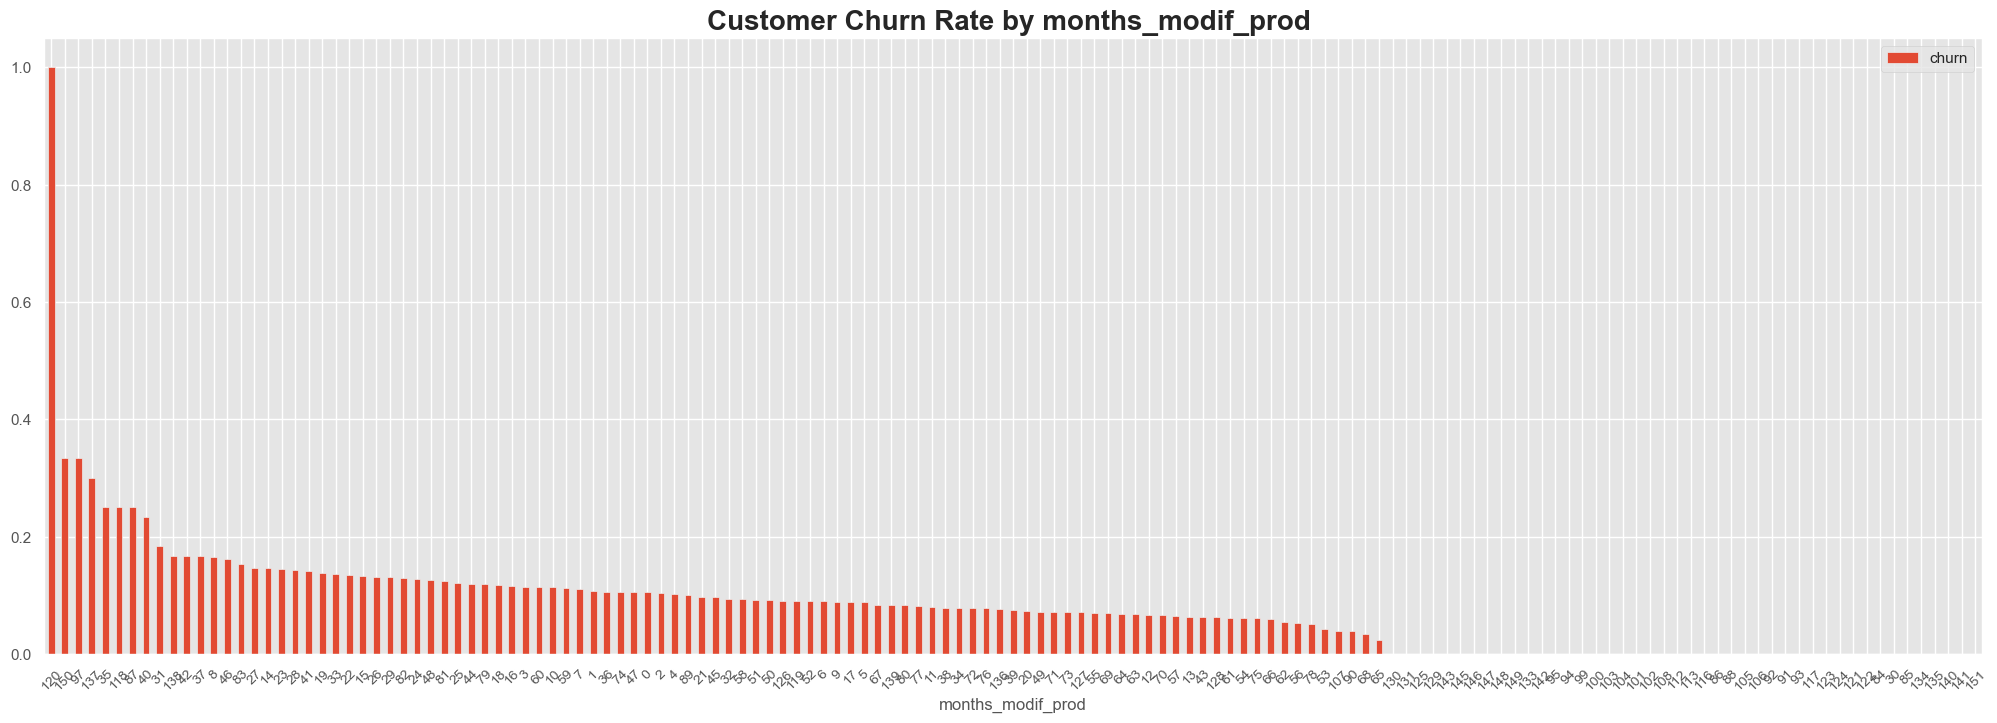

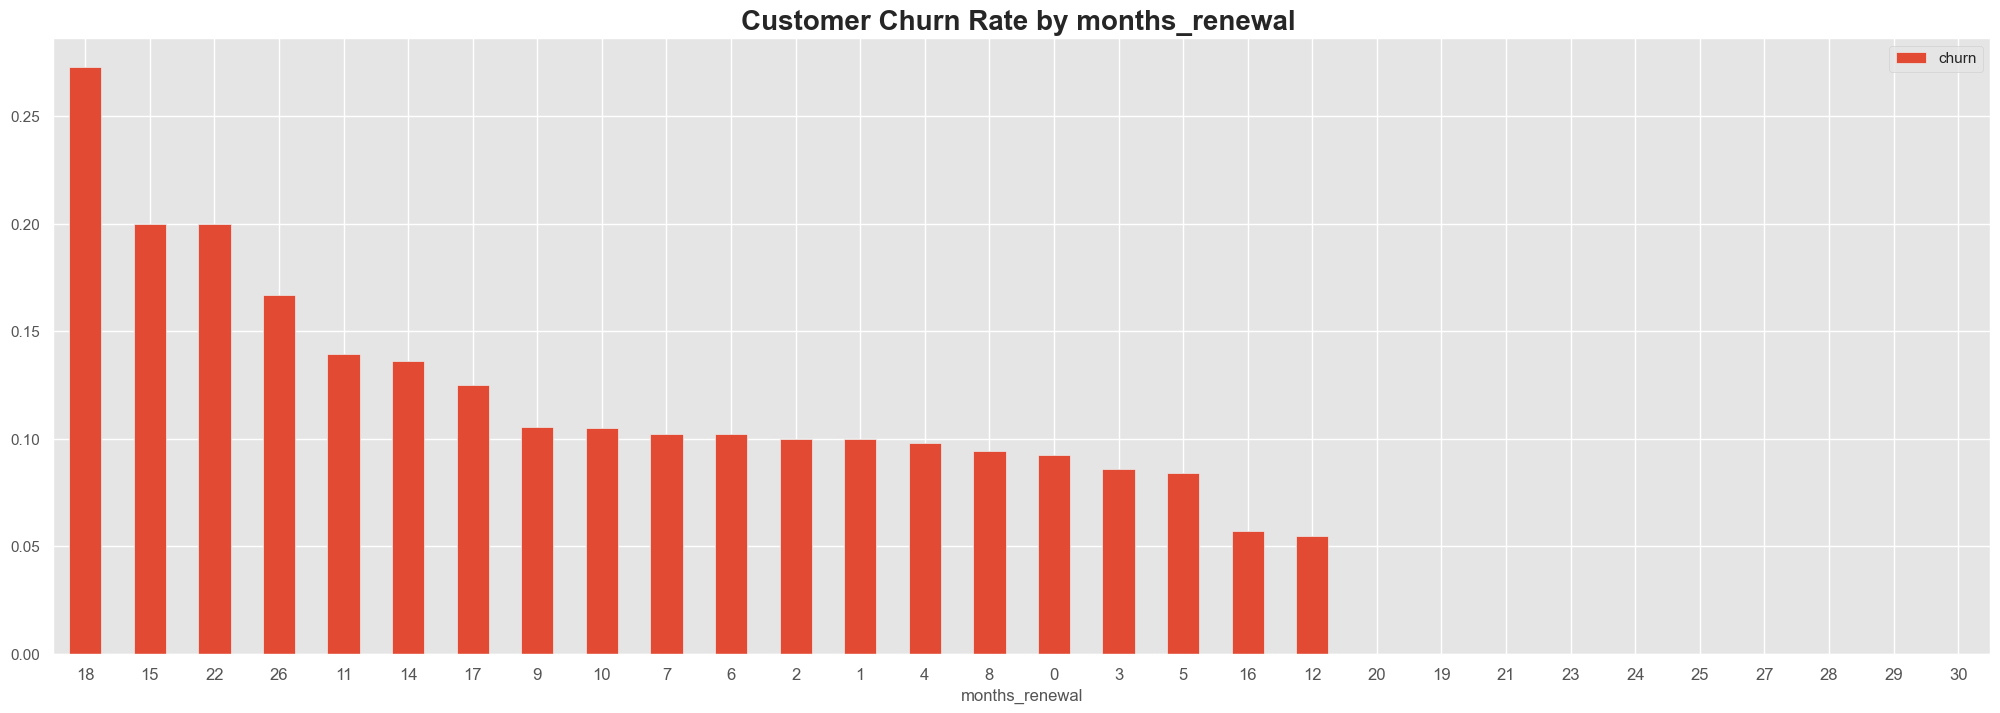

In [24]:
columns = ['months_activ','months_to_end','months_modif_prod','months_renewal']
x_tick_rot_list = [45,360,45,360]
x_tick_font_size_list = [10,12,10,12]

for col,x_tick_rot,x_tick_font_size in zip(columns,x_tick_rot_list,x_tick_font_size_list) : 
    df.groupby([col]).agg({'churn': 'mean'}).sort_values(by='churn', ascending=False).plot(kind='bar',rot=x_tick_rot, figsize = (25,8))
    plt.title(f'Customer Churn Rate by {col} ', weight = 'bold', fontsize = 20)
    plt.xticks(fontsize=x_tick_font_size)
    plt.show()

there might be association between months_activ/months_modif_prod/months_renewal and churn

---
## 4. Data Preprocessing
### Encoding Categorical Data for Predictive Modeling

A predictive model cannot accept categorical or `string` values, hence as a data scientist you need to encode categorical features into numerical representations in the most compact and discriminative way possible.

The simplest method is to map each category to an integer (label encoding), however this is not always appropriate beecause it then introduces the concept of an order into a feature which may not inherently be present `0 < 1 < 2 < 3 ...`

Another way to encode categorical features is to use `dummy variables` AKA `one hot encoding`. This create a new feature for every unique value of a categorical column, and fills this column with either a 1 or a 0 to indicate that this company does or does not belong to this category.

#### has_gas

Transform this column from being categorical to being a binary flag

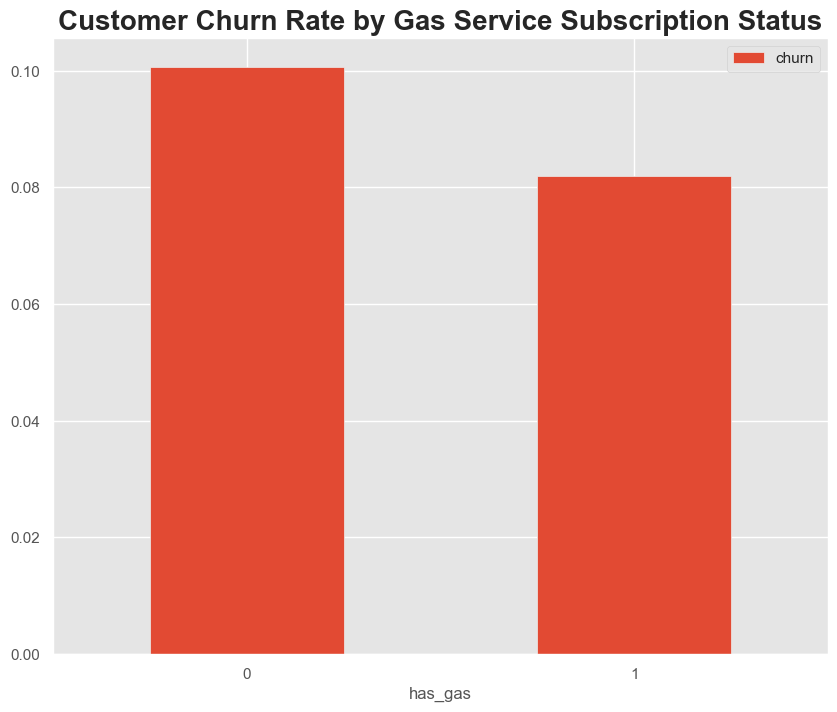

In [25]:
df['has_gas'] = df['has_gas'].replace(['t', 'f'], [1, 0])
df.groupby(['has_gas']).agg({'churn': 'mean'}).plot(kind='bar',rot=360, figsize=(10,8))
plt.title('Customer Churn Rate by Gas Service Subscription Status', weight = 'bold', fontsize = 20)
plt.show()

If a customer also buys gas from PowerCo, it shows that they have multiple products and are a loyal customer to the brand. Hence, it is no surprise that customers who do not buy gas are almost 2% more likely to churn than customers who also buy gas from PowerCo. Hence, this is a useful feature.

#### channel_sales

In [26]:
# Transform into categorical type
df['channel_sales'] = df['channel_sales'].astype('category')

# Let's see how many categories are within this column
df['channel_sales'].value_counts()

channel_sales
foosdfpfkusacimwkcsosbicdxkicaua    6754
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: count, dtype: int64

We have 8 categories, so we will create 8 dummy variables from this column. However, as you can see the last 3 categories in the output above, show that they only have 11, 3 and 2 occurrences respectively. Considering that our dataset has about 14000 rows, this means that these dummy variables will be almost entirely 0 and so will not add much predictive power to the model at all (since they're almost entirely a constant value and provide very little).

For this reason, we will drop these 3 dummy variables.

In [27]:
df = pd.get_dummies(df, columns=['channel_sales'], prefix='channel')
df = df.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])
df.head()

id  cons_12m  cons_gas_12m  cons_last_month  \
0  24011ae4ebbe3035111d65fa7c15bc57         0         54946                0   
1  d29c2c54acc38ff3c0614d0a653813dd      4660             0                0   
2  764c75f661154dac3a6c254cd082ea7d       544             0                0   
3  bba03439a292a1e166f80264c16191cb      1584             0                0   
4  149d57cf92fc41cf94415803a877cb4b      4425             0              526   

   forecast_cons_12m  forecast_cons_year  forecast_discount_energy  \
0               0.00                   0                       0.0   
1             189.95                   0                       0.0   
2              47.96                   0                       0.0   
3             240.04                   0                       0.0   
4             445.75                 526                       0.0   

   forecast_meter_rent_12m  forecast_price_energy_off_peak  \
0                     1.78                        0.114481   
1                    16.27                        0.145711   
2                    38.72                        0.165794   
3                    19.83                        0.146694   
4                   131.73                        0.116900   

   forecast_price_energy_peak  ...  tenure  months_activ  months_to_end  \
0                    0.098142  ...       3            30              5   
1                    0.000000  ...       7            76              7   
2                    0.087899  ...       6            68              3   
3                    0.000000  ...       6            69              2   
4                    0.100015  ...       6            71              2   

   months_modif_prod  months_renewal  channel_MISSING  \
0                  2               6            False   
1                 76               4             True   
2                 68               8            False   
3                 69               9            False   
4                 71               9             True   

   channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   

   channel_foosdfpfkusacimwkcsosbicdxkicaua  \
0                                      True   
1                                     False   
2                                      True   
3                                     False   
4                                     False   

  channel_lmkebamcaaclubfxadlmueccxoimlema  \
0                                    False   
1                                    False   
2                                    False   
3                                     True   
4                                    False   

   channel_usilxuppasemubllopkaafesmlibmsdf  
0                                     False  
1                                     False  
2                                     False  
3                                     False  
4                                     False  

[5 rows x 49 columns]

#### origin_up

In [28]:
# Transform into categorical type
df['origin_up'] = df['origin_up'].astype('category')

# Let's see how many categories are within this column
df['origin_up'].value_counts()

origin_up
lxidpiddsbxsbosboudacockeimpuepw    7097
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: count, dtype: int64

Similar to `channel_sales` the last 3 categories in the output above show very low frequency, so we will remove these from the features after creating dummy variables.

In [29]:
df = pd.get_dummies(df, columns=['origin_up'], prefix='origin_up')
df = df.drop(columns=['origin_up_MISSING', 'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
df.head()

id  cons_12m  cons_gas_12m  cons_last_month  \
0  24011ae4ebbe3035111d65fa7c15bc57         0         54946                0   
1  d29c2c54acc38ff3c0614d0a653813dd      4660             0                0   
2  764c75f661154dac3a6c254cd082ea7d       544             0                0   
3  bba03439a292a1e166f80264c16191cb      1584             0                0   
4  149d57cf92fc41cf94415803a877cb4b      4425             0              526   

   forecast_cons_12m  forecast_cons_year  forecast_discount_energy  \
0               0.00                   0                       0.0   
1             189.95                   0                       0.0   
2              47.96                   0                       0.0   
3             240.04                   0                       0.0   
4             445.75                 526                       0.0   

   forecast_meter_rent_12m  forecast_price_energy_off_peak  \
0                     1.78                        0.114481   
1                    16.27                        0.145711   
2                    38.72                        0.165794   
3                    19.83                        0.146694   
4                   131.73                        0.116900   

   forecast_price_energy_peak  ...  months_modif_prod  months_renewal  \
0                    0.098142  ...                  2               6   
1                    0.000000  ...                 76               4   
2                    0.087899  ...                 68               8   
3                    0.000000  ...                 69               9   
4                    0.100015  ...                 71               9   

   channel_MISSING  channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
0            False                                     False   
1             True                                     False   
2            False                                     False   
3            False                                     False   
4             True                                     False   

   channel_foosdfpfkusacimwkcsosbicdxkicaua  \
0                                      True   
1                                     False   
2                                      True   
3                                     False   
4                                     False   

   channel_lmkebamcaaclubfxadlmueccxoimlema  \
0                                     False   
1                                     False   
2                                     False   
3                                      True   
4                                     False   

   channel_usilxuppasemubllopkaafesmlibmsdf  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   

   origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws  \
0                                       False   
1                                        True   
2                                        True   
3                                        True   
4                                        True   

   origin_up_ldkssxwpmemidmecebumciepifcamkci  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                       False   

   origin_up_lxidpiddsbxsbosboudacockeimpuepw  
0                                        True  
1                                       False  
2                                       False  
3                                       False  
4                                       False  

[5 rows x 51 columns]

---
### Addressing Skewness in Numerical Data

In the previous exercise we saw that some variables were highly skewed. The reason why we need to treat skewness is because some predictive models have inherent assumptions about the distribution of the features that are being supplied to it. Such models are called `parametric` models, and they typically assume that all variables are both independent and normally distributed. 

Skewness isn't always a bad thing, but as a rule of thumb it is always good practice to treat highly skewed variables because of the reason stated above, but also as it can improve the speed at which predictive models are able to converge to its best solution.

There are many ways that you can treat skewed variables. You can apply transformations such as:
- Square root
- Cubic root
- Logarithm

to a continuous numeric column and you will notice the distribution changes. For this use case we will use the 'Logarithm' transformation for the positively skewed features. 

<b>Note:</b> We cannot apply log to a value of 0, so we will add a constant of 1 to all the values

First I want to see the statistics of the skewed features, so that we can compare before and after transformation

#### original columns in dataset

In [30]:
skewed = [
    'cons_12m', 
    'cons_gas_12m', 
    'cons_last_month',
    'forecast_cons_12m', 
    'forecast_cons_year', 
    'forecast_discount_energy',
    'forecast_meter_rent_12m', 
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak', 
    'forecast_price_pow_off_peak'
]

# Calculate skewness for each column in the skewed list
skewness_values = df[skewed].apply(lambda x: skew(x.dropna()))

# Display skewness values
skewness_values


cons_12m                           5.996692
cons_gas_12m                       9.596544
cons_last_month                    6.390751
forecast_cons_12m                  7.155118
forecast_cons_year                16.586286
forecast_discount_energy           5.154569
forecast_meter_rent_12m            1.504993
forecast_price_energy_off_peak    -0.119574
forecast_price_energy_peak        -0.014330
forecast_price_pow_off_peak       -4.998259
dtype: float64

We can see that the skewness for most of these features is quite high.

In [31]:
# Apply log10 transformation
df["cons_12m"] = np.log10(df["cons_12m"] + 1)
df["cons_gas_12m"] = np.log10(df["cons_gas_12m"] + 1)
df["cons_last_month"] = np.log10(df["cons_last_month"] + 1)
df["forecast_cons_12m"] = np.log10(df["forecast_cons_12m"] + 1)
df["forecast_cons_year"] = np.log10(df["forecast_cons_year"] + 1)
df["forecast_meter_rent_12m"] = np.log10(df["forecast_meter_rent_12m"] + 1)
df["imp_cons"] = np.log10(df["imp_cons"] + 1)

In [32]:
# Calculate skewness for each column in the skewed list
skewness_values = df[skewed].apply(lambda x: skew(x.dropna()))

# Display skewness values
skewness_values

cons_12m                         -0.379502
cons_gas_12m                      1.875532
cons_last_month                  -0.190677
forecast_cons_12m                -2.032543
forecast_cons_year               -0.118636
forecast_discount_energy          5.154569
forecast_meter_rent_12m          -0.603576
forecast_price_energy_off_peak   -0.119574
forecast_price_energy_peak       -0.014330
forecast_price_pow_off_peak      -4.998259
dtype: float64

Now we can see that for the majority of the features, their skewness is much lower after transformation. This is a good thing, it shows that these features are more stable and predictable now.

Let's quickly check the distributions of some of these features too.

/var/folders/lt/0c8vrg812nl928pftmdzt1xw0000gn/T/ipykernel_85940/1161214023.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
/var/folders/lt/0c8vrg812nl928pftmdzt1xw0000gn/T/ipykernel_85940/1161214023.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((d

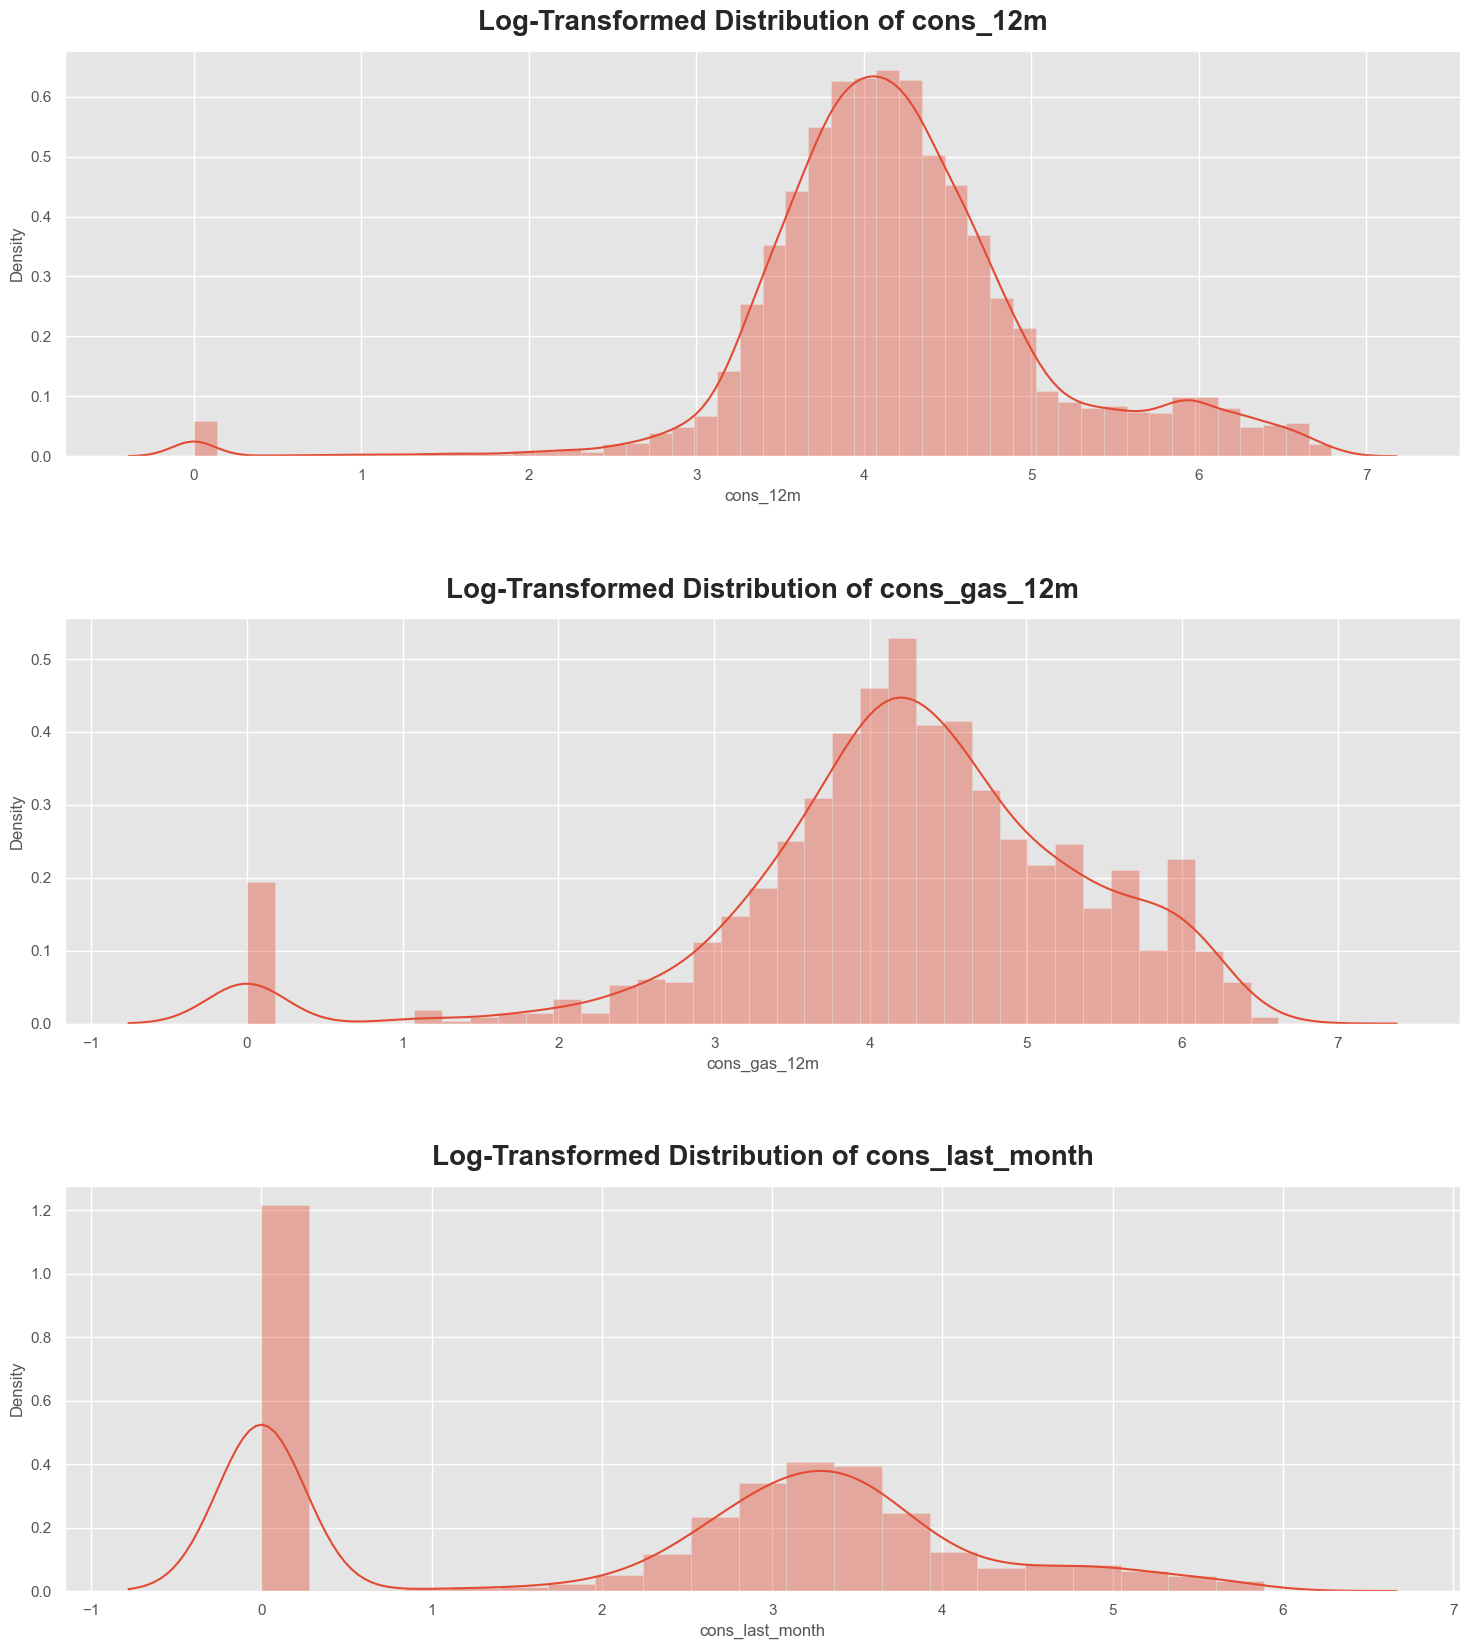

In [33]:
fig, axs = plt.subplots(nrows=3, figsize=(18, 20))


# Plot histograms
sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.distplot((df["cons_last_month"].dropna()), ax=axs[2])

axs[0].set_title("Log-Transformed Distribution of cons_12m", fontsize=20, weight = 'bold', pad=15)
axs[1].set_title("Log-Transformed Distribution of cons_gas_12m", fontsize=20, weight = 'bold', pad=15)
axs[2].set_title("Log-Transformed Distribution of cons_last_month", fontsize=20, weight = 'bold', pad=15)
plt.subplots_adjust(hspace=0.4)
plt.show()

#### columns derived from feature engineering

In [34]:
columns = [ 'offpeak_diff_dec_january_energy', 'offpeak_diff_dec_january_power',
       'peak_diff_dec_january_energy', 'peak_diff_dec_january_power',
       'midpeak_diff_dec_january_energy', 'midpeak_diff_dec_january_power',
       'peak_off_peak_var_mean_diff', 'mid_peak_peak_var_mean_diff',
       'off_peak_mid_peak_var_mean_diff', 'peak_off_peak_fix_mean_diff',
       'mid_peak_peak_fix_mean_diff', 'off_peak_mid_peak_fix_mean_diff',
       'peak_off_peak_var_max_monthly_diff',
       'mid_peak_peak_var_max_monthly_diff',
       'off_peak_mid_peak_var_max_monthly_diff',
       'peak_off_peak_fix_max_monthly_diff',
       'mid_peak_peak_fix_max_monthly_diff',
       'off_peak_mid_peak_fix_max_monthly_diff']

# Calculate skewness for each column in the skewed list
skewness_values = df[columns].apply(lambda x: skew(x.dropna()))

# Display skewness values
skewness_values



offpeak_diff_dec_january_energy           3.377298
offpeak_diff_dec_january_power           -9.277423
peak_diff_dec_january_energy              1.228912
peak_diff_dec_january_power              -4.695447
midpeak_diff_dec_january_energy          -3.197900
midpeak_diff_dec_january_power           -5.345164
peak_off_peak_var_mean_diff               0.059505
mid_peak_peak_var_mean_diff              -1.283273
off_peak_mid_peak_var_mean_diff          -0.301900
peak_off_peak_fix_mean_diff               0.488733
mid_peak_peak_fix_mean_diff              -1.903512
off_peak_mid_peak_fix_mean_diff          -0.683035
peak_off_peak_var_max_monthly_diff        0.042460
mid_peak_peak_var_max_monthly_diff       -0.912982
off_peak_mid_peak_var_max_monthly_diff   -0.317644
peak_off_peak_fix_max_monthly_diff        0.588979
mid_peak_peak_fix_max_monthly_diff       -1.882922
off_peak_mid_peak_fix_max_monthly_diff   -0.773461
dtype: float64

Since the skewness values for most of these columns are not extreme, so only apply transformations to 'offpeak_diff_dec_january_power'

In [35]:
df["offpeak_diff_dec_january_power"] = np.log10(df["offpeak_diff_dec_january_power"] + 1)

/opt/miniconda3/envs/ml/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [36]:
skewness_values = df[['offpeak_diff_dec_january_power']].apply(lambda x: skew(x.dropna()))
skewness_values

offpeak_diff_dec_january_power    3.41822
dtype: float64

/var/folders/lt/0c8vrg812nl928pftmdzt1xw0000gn/T/ipykernel_85940/3354071404.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((df['offpeak_diff_dec_january_power'].dropna()), ax=axs)


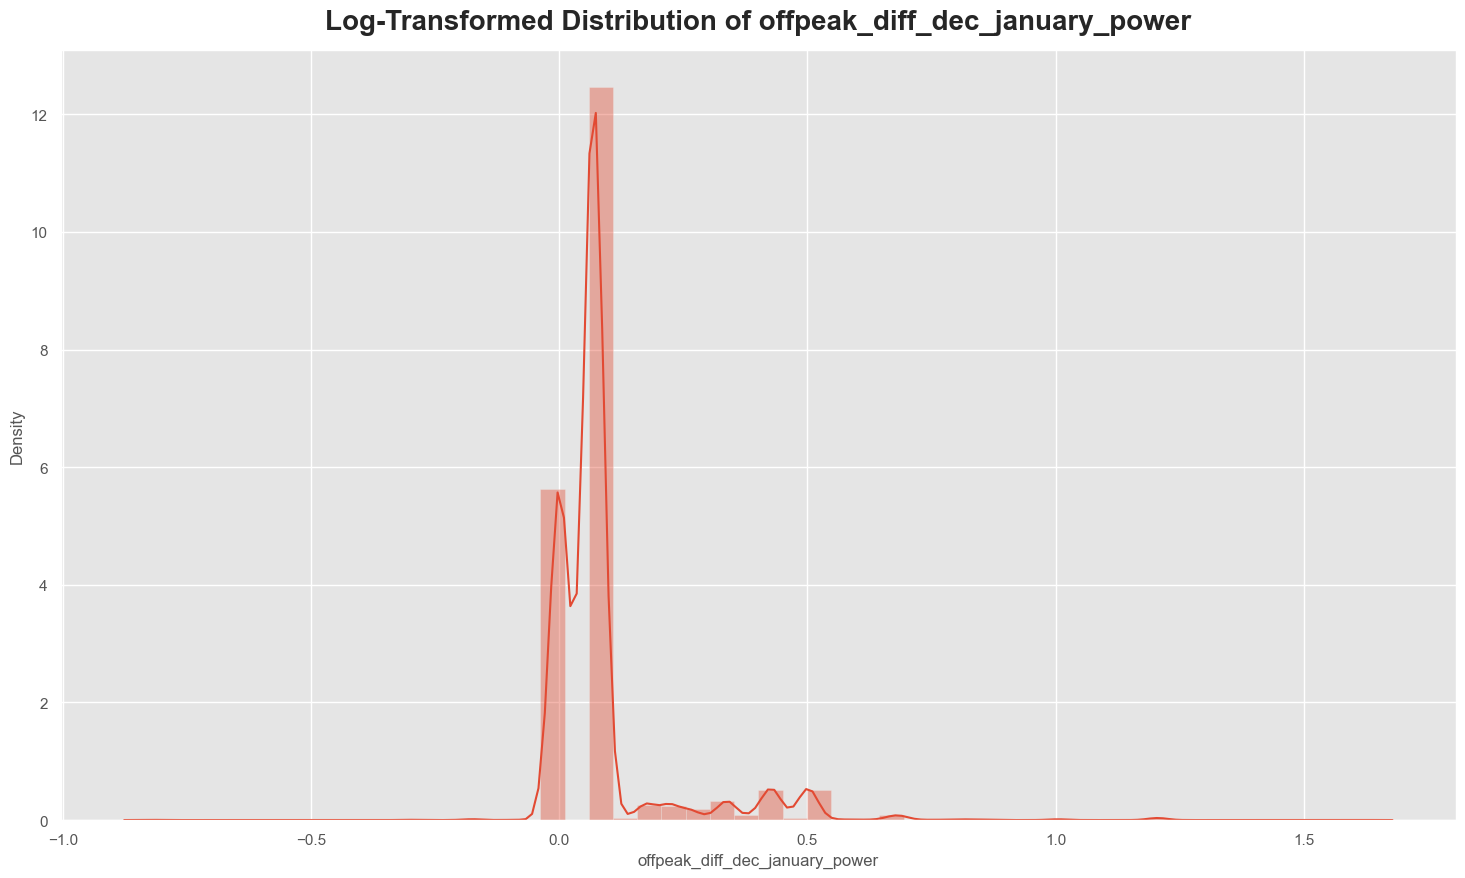

In [37]:
fig, axs = plt.subplots(nrows=1, figsize=(18, 10))
sns.distplot((df['offpeak_diff_dec_january_power'].dropna()), ax=axs)
axs.set_title("Log-Transformed Distribution of offpeak_diff_dec_january_power", fontsize=20, weight = 'bold', pad=15)

plt.show()

---
### Correlation Analysis

Another thing that is always useful to look at is how correlated all of the features are within your dataset.

One of the assumptions of any parametric predictive model (as stated earlier) is that all features must be independent.

For features to be independent, this means that each feature must have absolutely no dependence on any other feature. If two features are highly correlated and share similar information, this breaks this assumption. 

Ideally, you want a set of features that have 0 correlation with all of the independent variables (all features except our target variable) and a high correlation with the target variable (churn). However, this is very rarely the case and it is common to have a small degree of correlation between independent features.

So now let's look at how all the features within the model are correlated.

In [38]:
columns = ['cons_12m', 'cons_gas_12m', 'cons_last_month',
       'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'pow_max', 'churn',
       'offpeak_diff_dec_january_energy', 'offpeak_diff_dec_january_power',
       'peak_diff_dec_january_energy', 'peak_diff_dec_january_power',
       'midpeak_diff_dec_january_energy', 'midpeak_diff_dec_january_power',
       'peak_off_peak_var_mean_diff', 'mid_peak_peak_var_mean_diff',
       'off_peak_mid_peak_var_mean_diff', 'peak_off_peak_fix_mean_diff',
       'mid_peak_peak_fix_mean_diff', 'off_peak_mid_peak_fix_mean_diff',
       'peak_off_peak_var_max_monthly_diff',
       'mid_peak_peak_var_max_monthly_diff',
       'off_peak_mid_peak_var_max_monthly_diff',
       'peak_off_peak_fix_max_monthly_diff',
       'mid_peak_peak_fix_max_monthly_diff',
       'off_peak_mid_peak_fix_max_monthly_diff', 'tenure', 'months_activ',
       'months_to_end', 'months_modif_prod', 'months_renewal']

correlation_matrix = df[columns].corr(numeric_only=True)

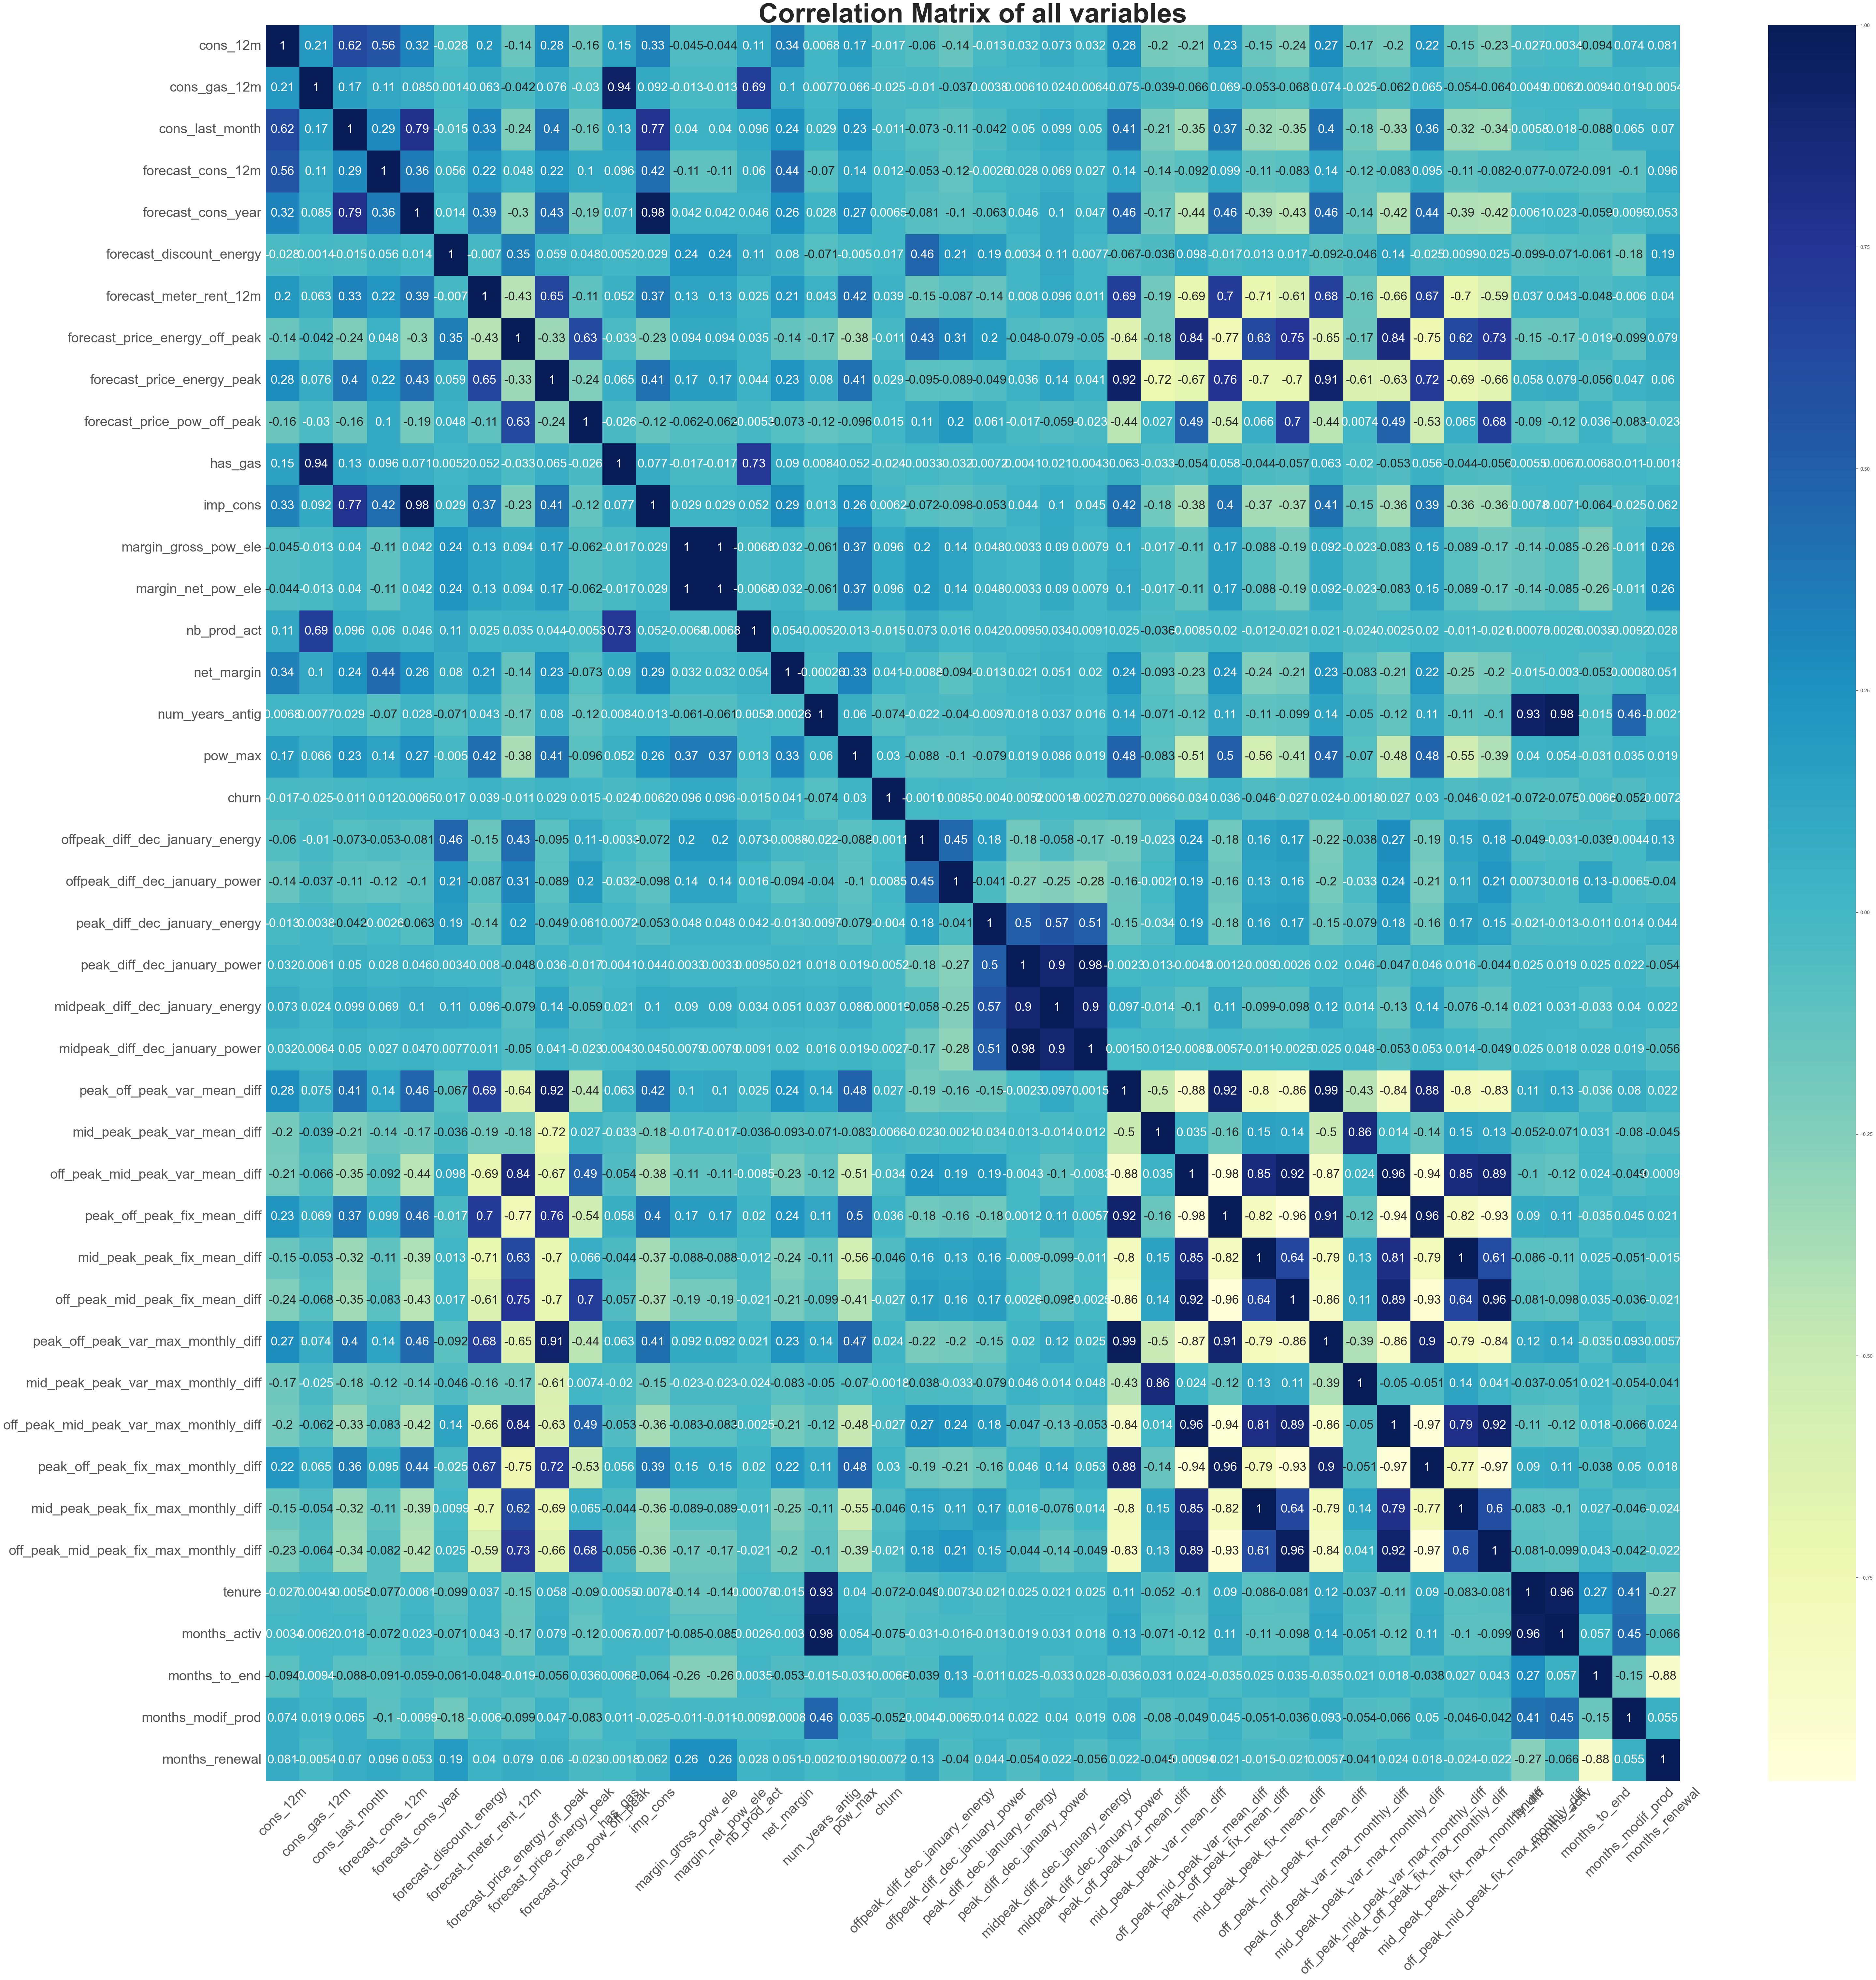

In [39]:
fig = plt.figure(figsize=(70,70))
sns.heatmap(correlation_matrix,cmap="YlGnBu",annot_kws={'size': 27}, annot=True)
plt.title('Correlation Matrix of all variables', weight = 'bold', fontsize = 60)
plt.xticks(fontsize=30,rotation=45)
plt.yticks(fontsize=30)
plt.show()

Since there are too many columns in dataframe, the heatmap is a bit messy. Therefore, I'll filter out pairs of variables which have high correlation manually

In [40]:
# Find pairs with correlation > 0.9 (excluding self-correlation of 1.0)
high_correlation_pairs = (
    correlation_matrix
    .where((abs(correlation_matrix) > 0.9) & (correlation_matrix != 1.0))
    .stack()
    .reset_index()
)

# Rename columns for better readability
high_correlation_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

high_correlation_pairs['Sorted Pair'] = high_correlation_pairs.apply(
    lambda row: tuple(sorted([row['Variable 1'], row['Variable 2']])), axis=1
)

unique_high_correlation_pairs = high_correlation_pairs.drop_duplicates(subset=['Sorted Pair']).drop(columns=['Sorted Pair'])
# Display high-correlation pairs
unique_high_correlation_pairs = unique_high_correlation_pairs.sort_values(by=['Variable 1','Variable 2']).reset_index(drop=True)
unique_high_correlation_pairs

Variable 1  \
0                             cons_gas_12m   
1                       forecast_cons_year   
2               forecast_price_energy_peak   
3               forecast_price_energy_peak   
4                     margin_gross_pow_ele   
5              mid_peak_peak_fix_mean_diff   
6          midpeak_diff_dec_january_energy   
7                          num_years_antig   
8                          num_years_antig   
9          off_peak_mid_peak_fix_mean_diff   
10         off_peak_mid_peak_fix_mean_diff   
11  off_peak_mid_peak_var_max_monthly_diff   
12  off_peak_mid_peak_var_max_monthly_diff   
13         off_peak_mid_peak_var_mean_diff   
14         off_peak_mid_peak_var_mean_diff   
15         off_peak_mid_peak_var_mean_diff   
16         off_peak_mid_peak_var_mean_diff   
17             peak_diff_dec_january_power   
18             peak_diff_dec_january_power   
19      peak_off_peak_fix_max_monthly_diff   
20             peak_off_peak_fix_mean_diff   
21             peak_off_peak_fix_mean_diff   
22             peak_off_peak_fix_mean_diff   
23             peak_off_peak_fix_mean_diff   
24             peak_off_peak_fix_mean_diff   
25             peak_off_peak_var_mean_diff   
26             peak_off_peak_var_mean_diff   
27                                  tenure   

                                Variable 2  Correlation  
0                                  has_gas     0.941198  
1                                 imp_cons     0.984266  
2       peak_off_peak_var_max_monthly_diff     0.914969  
3              peak_off_peak_var_mean_diff     0.924753  
4                       margin_net_pow_ele     0.999914  
5       mid_peak_peak_fix_max_monthly_diff     0.996595  
6           midpeak_diff_dec_january_power     0.904760  
7                             months_activ     0.984244  
8                                   tenure     0.928386  
9   off_peak_mid_peak_fix_max_monthly_diff     0.963763  
10      peak_off_peak_fix_max_monthly_diff    -0.927341  
11  off_peak_mid_peak_fix_max_monthly_diff     0.917911  
12      peak_off_peak_fix_max_monthly_diff    -0.968899  
13         off_peak_mid_peak_fix_mean_diff     0.923536  
14  off_peak_mid_peak_var_max_monthly_diff     0.964592  
15      peak_off_peak_fix_max_monthly_diff    -0.940070  
16             peak_off_peak_fix_mean_diff    -0.979131  
17         midpeak_diff_dec_january_energy     0.902356  
18          midpeak_diff_dec_january_power     0.983344  
19  off_peak_mid_peak_fix_max_monthly_diff    -0.965950  
20  off_peak_mid_peak_fix_max_monthly_diff    -0.927386  
21         off_peak_mid_peak_fix_mean_diff    -0.963676  
22  off_peak_mid_peak_var_max_monthly_diff    -0.938122  
23      peak_off_peak_fix_max_monthly_diff     0.960045  
24      peak_off_peak_var_max_monthly_diff     0.909583  
25             peak_off_peak_fix_mean_diff     0.920161  
26      peak_off_peak_var_max_monthly_diff     0.991270  
27                            months_activ     0.956408

#### Suggestions for Dropping Columns
There are lots of variables pairs with high correlation. Therefore, we would want to drop some variables to ensure the independence between variables.

drop 
- has_gas
- forecast_cons_year
- forecast_price_energy_peak
- margin_gross_pow_ele
- mid_peak_peak_fix_mean_diff
- midpeak_diff_dec_january_energy
- num_years_antig
- months_activ
- off_peak_mid_peak_fix_mean_diff
- off_peak_mid_peak_var_max_monthly_diff
- off_peak_mid_peak_var_mean_diff
- peak_diff_dec_january_power
- peak_off_peak_fix_max_monthly_diff
- peak_off_peak_fix_mean_diff

In [41]:
columns_to_drop = [
    'has_gas',
    'forecast_cons_year',
    'forecast_price_energy_peak',
    'margin_gross_pow_ele',
    'mid_peak_peak_fix_mean_diff',
    'midpeak_diff_dec_january_energy',
    'num_years_antig',
    'months_activ',
    'off_peak_mid_peak_fix_mean_diff',
    'off_peak_mid_peak_var_max_monthly_diff',
    'off_peak_mid_peak_var_mean_diff',
    'peak_diff_dec_january_power',
    'peak_off_peak_fix_max_monthly_diff',
    'peak_off_peak_fix_mean_diff'
]

df = df.drop(columns_to_drop, axis = 1)
df.head()

id  cons_12m  cons_gas_12m  cons_last_month  \
0  24011ae4ebbe3035111d65fa7c15bc57  0.000000      4.739944         0.000000   
1  d29c2c54acc38ff3c0614d0a653813dd  3.668479      0.000000         0.000000   
2  764c75f661154dac3a6c254cd082ea7d  2.736397      0.000000         0.000000   
3  bba03439a292a1e166f80264c16191cb  3.200029      0.000000         0.000000   
4  149d57cf92fc41cf94415803a877cb4b  3.646011      0.000000         2.721811   

   forecast_cons_12m  forecast_discount_energy  forecast_meter_rent_12m  \
0           0.000000                       0.0                 0.444045   
1           2.280920                       0.0                 1.237292   
2           1.689841                       0.0                 1.599009   
3           2.382089                       0.0                 1.318689   
4           2.650065                       0.0                 2.122969   

   forecast_price_energy_off_peak  forecast_price_pow_off_peak  imp_cons  ...  \
0                        0.114481                    40.606701   0.00000  ...   
1                        0.145711                    44.311378   0.00000  ...   
2                        0.165794                    44.311378   0.00000  ...   
3                        0.146694                    44.311378   0.00000  ...   
4                        0.116900                    40.606701   1.72689  ...   

   months_modif_prod  months_renewal  channel_MISSING  \
0                  2               6            False   
1                 76               4             True   
2                 68               8            False   
3                 69               9            False   
4                 71               9             True   

   channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   

   channel_foosdfpfkusacimwkcsosbicdxkicaua  \
0                                      True   
1                                     False   
2                                      True   
3                                     False   
4                                     False   

   channel_lmkebamcaaclubfxadlmueccxoimlema  \
0                                     False   
1                                     False   
2                                     False   
3                                      True   
4                                     False   

   channel_usilxuppasemubllopkaafesmlibmsdf  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   

   origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws  \
0                                       False   
1                                        True   
2                                        True   
3                                        True   
4                                        True   

   origin_up_ldkssxwpmemidmecebumciepifcamkci  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                       False   

   origin_up_lxidpiddsbxsbosboudacockeimpuepw  
0                                        True  
1                                       False  
2                                       False  
3                                       False  
4                                       False  

[5 rows x 37 columns]

---
## 5. Export the data for modeling

In [42]:
#df.to_csv('data_for_modeling.csv')